# Prediction of relevant protein kinase-cancer relations
We aim to learn pairs (x,y), where x is a protein kinase and y is a cancer that 
can be effectively treated by inhibiting x. We use word2vec to embed words found
in abstracts from the PubMed corpus; we use [marea](https://github.com/TheJacksonLaboratory/marea) to preprocess PubMed abstracts by replacing words and phrases with concept IDs, followed by analysis with [embiggen](https://pypi.org/project/embiggen/) for word embedding. This notebook imports the embedded vectors and corresponding labels (words) from embiggen. We then extract vectors that correspond to
both protein kinases and cancers. We use a positive set of (x,y) relations that
we have derived from an analysis of Clinical Trials data with [yatcp](https://github.com/monarch-initiative/yactp), and rank other possible protein-kinase cancer relations.

## How to set up this notebook
This notebook depends on the files ``embedding_SG_dim100_upto2020.npy``, ``words_SG_upto2020.txt`` (from embiggen), 
``KCET_positive_2021.tsv``, and ``KCET_prediction_2021.tsv`` from the [KCET](https://github.com/TheJacksonLaboratory/KCET) package. For now, the corresponding files are available in
Google drive. Download that folder to someplace on your drive, and then cd to the KCET/notebooks folder,
and softlist the downloaded folder
```
ln -s /path/to/downloaded/folder/ data
```
This notebook assumes it will find the files there.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sys.path.insert(0, os.path.abspath('..'))
from kcet import KinasePredictor

## Input files
``embedding_Skipgram_dim100.npy`` is the result of word2vec embedding of pubmed. ``words.txt`` are the corresponding words. A directory of files was downloaded and softlinked to data using ``ln -s <path> data``.

In [2]:
data_directory = 'data'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")
#embedding_file = os.path.join(data_directory, "embedding_skipgram_dim100.npy")
embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto2020.npy")
words_file = os.path.join(data_directory, "words_upto2020.txt")
predictor = KinasePredictor(embeddings=embedding_file, words=words_file)


[INFO] We ingested 279074 labeled word vectors from data/embedding_SG_dim100_before2021_jan17.npy and data/words_before2021_jan17.txt
[INFO] We ingested 522 symbol/NCBI gene id mappings from /Users/ravanv/PycharmProjects/KCET/input/prot_kinase.tsv
[INFO] We ingested 694 meshId/disease mappings from /Users/ravanv/PycharmProjects/KCET/input/neoplasms_labels.tsv



# PubMed Word Embeddings
The following code displays the numbers of word embeddings used as input.

In [3]:
embeddings = predictor.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,4.889051,-0.031666,0.338668,-3.837982,5.064051,3.183400,-7.890838,5.760468,-2.252833,-5.960526,...,4.204287,-0.621916,5.796295,-4.361966,-3.195167,4.308964,0.216601,-1.855917,-3.194237,0.313202
patient,3.924797,0.219617,0.953061,-4.449959,5.459194,4.111465,-8.687608,3.530771,-2.323123,-4.462675,...,2.524319,0.027388,7.379459,-5.720111,-4.482318,4.162126,1.568093,-0.978158,-3.376686,-0.109741
meshd009369,3.881120,-0.227235,0.395009,-3.596462,5.173261,3.809950,-8.075894,5.201393,-2.407287,-5.387233,...,4.061015,-0.497528,5.869024,-5.586808,-4.170487,4.449340,1.306108,-1.738820,-5.368866,0.187094
0,3.055454,-0.263832,0.920612,-4.864516,5.052263,4.029271,-8.058578,4.390298,-2.375837,-5.064628,...,2.799726,-0.442358,6.306581,-4.008514,-4.170806,4.458221,1.918985,-2.458562,-3.410570,-0.178341
study,3.177587,0.394009,0.676511,-3.332552,4.960812,3.781860,-7.468229,5.013127,-2.291365,-4.292953,...,2.137289,-0.415919,6.394296,-4.925942,-3.313363,2.946915,0.932657,-1.803408,-3.578388,-0.246187
1,4.276373,0.354697,0.665837,-3.893480,5.078850,2.301900,-7.876859,5.159957,-2.323680,-5.243721,...,3.839391,-0.217386,7.105384,-3.324035,-4.527849,3.727521,2.020938,-1.461752,-2.742688,-0.564641
use,3.324859,0.173641,0.465271,-4.312271,4.633897,3.153299,-7.484262,7.140862,-2.389421,-4.394421,...,1.703226,-0.175126,6.509904,-4.376715,-3.083380,3.313489,2.210718,-2.020195,-2.333418,0.027003
expression,3.135921,-0.355112,0.784373,-4.447850,4.763081,2.509020,-9.018481,5.281701,-2.314202,-4.732630,...,3.098506,-1.046487,5.030376,-4.265596,-3.297549,3.666695,1.070374,-1.083583,-5.500472,0.498087
treatment,4.133173,0.488513,0.545027,-4.853585,5.084430,3.782615,-8.237522,4.177872,-2.397287,-3.774137,...,1.868692,0.176320,5.984592,-5.739978,-2.203179,3.493302,2.137952,-2.185515,-3.390525,0.102645
2,4.712316,0.174669,0.730532,-4.471674,5.100173,2.307842,-8.195997,5.013849,-2.374854,-4.830081,...,3.901921,-0.248850,6.792335,-3.478672,-4.019910,4.114904,2.434609,-1.252051,-2.922599,-0.443214


In [4]:
print("Total number of embeddings: ", len(embeddings))

Total number of embeddings:  279074


# Positive examples
Note that we need to rename the gene.id to gene_id upstream TODO

In [5]:
positive_examples = os.path.join(data_directory, "KCET_positive_2021.tsv")
positive_df = pd.read_csv(positive_examples,  sep= "\t")[["mesh_id", "gene.id"]]
positive_df = positive_df.rename(columns={"gene.id": "gene_id"})
positive_df.head()

,mesh_id,gene_id
0,meshd002289,ncbigene1956
1,meshd002289,ncbigene2064
2,meshd002294,ncbigene1956
3,meshd002294,ncbigene2064
4,meshd008175,ncbigene1956


In [6]:
print("%d positive examples" % len(positive_df))
print("%d embedded words in total" % len(predictor.get_embeddings()))

62 positive examples
279074 embedded words in total


# Difference vectors
We form difference vectors by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``). The following function in the
KCET package takes the dataframe shown above, finds the corrresponding vectors, substracts them, and
returns a new Pandas dataframe.

In [7]:
diff_vectors_pos = predictor.get_disease_kinase_difference_vectors(examples=positive_df)

[INFO] Extracted 62 kinase-cancer difference vectors
[INFO]	Initial data: 62 examples
[INFO]	Could not identify 0 gene ids
[INFO]	Could not identify 0 MeSH ids


In [8]:
diff_vectors_pos.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1956-meshd002289,2.189870,-0.466689,-0.098385,0.241185,-0.241982,-2.480665,-0.281667,-0.498487,-0.066791,0.915691,...,-0.003205,-0.857294,-2.594050,0.723908,1.092950,-0.150143,-0.873464,-0.777208,0.621834,-0.582316
ncbigene2064-meshd002289,1.997948,-0.909466,-0.165297,-0.161491,-0.476931,-0.683900,0.014260,1.058111,0.136936,1.636533,...,1.115135,-0.645337,-2.503659,1.350376,0.984235,1.082525,0.034576,0.532850,-1.102190,-0.719152
ncbigene1956-meshd002294,1.332899,0.359267,0.654361,1.369661,-1.258430,-3.243458,-0.048450,-1.640862,-0.127330,4.118406,...,-0.755723,0.005592,0.475560,0.796344,0.532163,0.133237,-0.522667,-2.909063,1.265789,-0.093357
ncbigene2064-meshd002294,1.140977,-0.083510,0.587450,0.966985,-1.493380,-1.446693,0.247477,-0.084264,0.076398,4.839248,...,0.362617,0.217549,0.565951,1.422812,0.423448,1.365905,0.385374,-1.599005,-0.458234,-0.230194
ncbigene1956-meshd008175,2.150546,-0.264957,0.060147,1.162040,-0.392263,-2.833933,-0.790178,-1.875163,-0.098584,2.669825,...,-0.513041,-0.899361,-1.607996,-0.266547,1.951437,0.077035,-0.771136,-1.508945,0.789593,-0.550009


In [9]:
print("%d total difference vectors were extracted." % len(diff_vectors_pos))

62 total difference vectors were extracted.


# Negative examples
Here, we process negative examples in the same way. TODO LINK TO EXPLANATION OF HOW WE MAKE POS AND NEG

In [10]:
negative_examples = os.path.join(data_directory, "KCET_negative_2021.tsv")
negative_df = pd.read_csv(negative_examples,  sep= "\t")[["mesh_id", "gene_id"]]
negative_df.head()

,mesh_id,gene_id
0,meshd054198,ncbigene1018
1,meshd015192,ncbigene1859
2,meshd018312,ncbigene23097
3,meshd018240,ncbigene131890
4,meshd009376,ncbigene5058


In [11]:
print("%d negative examples" % len(negative_df))

620 negative examples


In [12]:
diff_vectors_neg = predictor.get_disease_kinase_difference_vectors(examples=negative_df)

[INFO] Extracted 581 kinase-cancer difference vectors
[INFO]	Initial data: 620 examples
[INFO]	Could not identify 12 gene ids
[INFO]	Could not identify 17 MeSH ids


In [13]:
diff_vectors_neg.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1018-meshd054198,0.103899,0.885684,0.687241,1.989926,-3.249061,-0.157379,3.767309,-2.500732,-0.043585,2.275461,...,-1.712197,-0.122994,-4.925032,3.173496,1.188878,-1.641086,0.509568,-1.066503,0.112508,0.382803
ncbigene1859-meshd015192,-0.227387,0.636755,0.736458,0.230168,-1.303867,-0.160546,2.658063,-0.079331,0.297263,1.684484,...,0.562159,0.045794,-1.495960,1.199635,1.036376,-0.533996,1.233389,-0.347364,0.409854,0.784485
ncbigene23097-meshd018312,-0.539040,0.609390,0.342695,1.144504,-2.004882,-0.852447,2.940399,-2.239879,0.606403,1.757795,...,-1.971231,0.481551,-2.430038,0.346538,-0.264939,-1.887620,1.361328,-0.255230,1.732940,1.962010
ncbigene131890-meshd018240,-0.647635,0.537655,1.018680,0.285206,-1.821212,-0.507014,2.519748,-1.606646,0.582275,1.929192,...,-1.393893,-0.368609,-1.658370,0.668047,-0.585912,-0.995681,1.094341,-0.338298,0.815220,1.530883
ncbigene5058-meshd009376,0.867788,1.009346,1.205338,0.067258,1.506702,0.782745,-1.922141,1.171159,-1.104338,-0.789970,...,1.118838,-1.129496,1.446721,-1.729755,-2.021156,0.784794,1.456880,-1.541305,-1.056086,-0.110134


# PCA visualization
To do PCA, we concatenate the positive and negative examples and label them so that we can visualize them using PCA.

In [77]:
X_train = diff_vectors_pos.append(diff_vectors_neg)
print("[INFO] We combined positive (n=%d) and negative (n=%d) to the combined dataframe (%d)" % 
      (len(diff_vectors_pos), len(diff_vectors_neg), len(X_train)))

[INFO] We combined positive (n=62) and negative (n=581) to the combined dataframe (643)


In [78]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = [ "red" if i < len(diff_vectors_pos) else "blue" for i in range(len(X_train))]

In [79]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.6787577  0.04071016 0.03427705]


No handles with labels found to put in legend.


Text(0, 0.5, 'PC 2 (4.07%)')

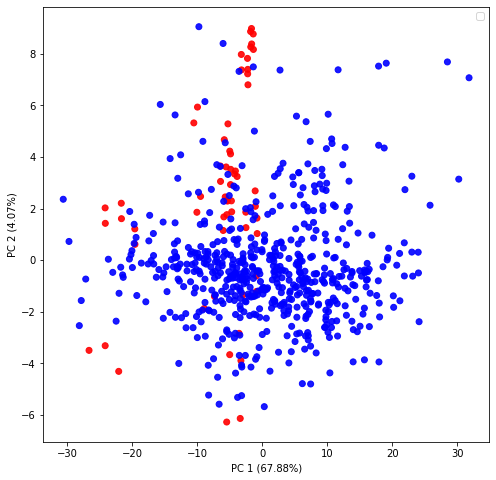

In [98]:
plt.figure(figsize=(8,8))
plt.scatter(pca_result[:,0], pca_result[:,1], c=cvec, alpha=0.9)
plt.legend()
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100))

# T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [18]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 643 samples in 0.000s...
[t-SNE] Computed neighbors for 643 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 643 / 643
[t-SNE] Mean sigma: 3.354748
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.817223
[t-SNE] KL divergence after 300 iterations: 0.812551
t-SNE done! Time elapsed: 1.4190161228179932 seconds


Text(0, 0.5, 'tsne-2d-two')

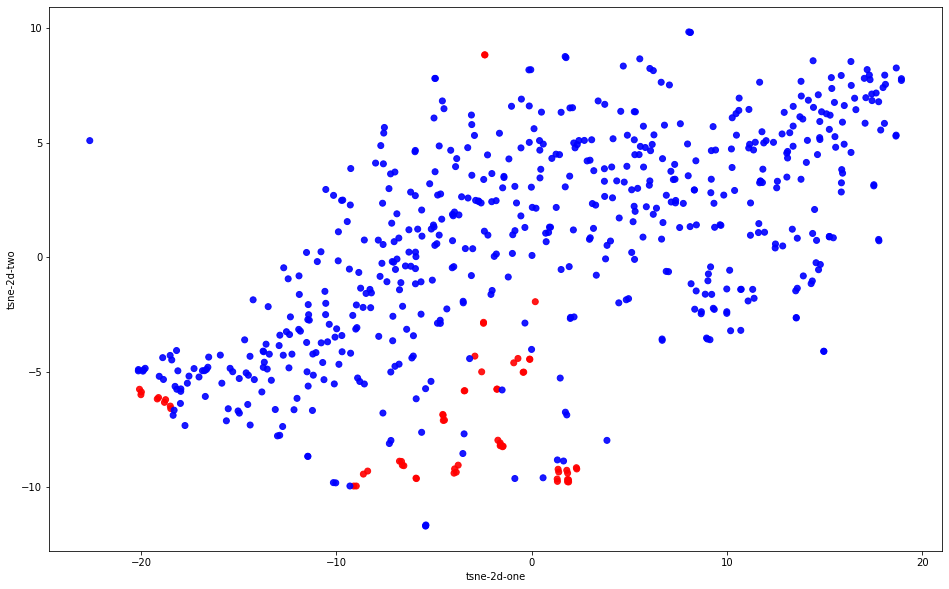

In [27]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec, alpha=0.9)
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two') 

# Random forest
First, let's arrange the training data. X_train we have from above. We additionally need to create a data structure for the labels with 1=positive, 0=negative example

In [21]:
print("Training data dimensions:", X_train.shape)

Training data dimensions: (643, 100)


In [22]:
label_1 = np.ones(diff_vectors_pos.shape[0])
label_0 = np.zeros(diff_vectors_neg.shape[0])
Y_train = np.concatenate((label_1,label_0))
n_pos_examples = sum([x for x in Y_train])
n_neg_examples = sum([(1-x) for x in Y_train])
print("Number of positive examples: %d, number of negative examples: %d, Y_train.shape: %s" % (n_pos_examples, n_neg_examples, Y_train.shape))

Number of positive examples: 62, number of negative examples: 581, Y_train.shape: (643,)


## Prediction data
Note that for this pilot experiment, we are not checking ROC, but we are just predicting values for all combinations of protein kinases and cancers

In [23]:
prediction_data = os.path.join(data_directory, "KCET_prediction_2021.tsv")
prediction_df = pd.read_csv(prediction_data, sep='\t')[["mesh_id", "gene_id"]]


In [24]:
prediction_df.head()

,mesh_id,gene_id
0,meshd000008,ncbigene23552
1,meshd000069293,ncbigene23552
2,meshd000069295,ncbigene23552
3,meshd000069584,ncbigene23552
4,meshd000070779,ncbigene23552


In [25]:
prediction_difference_vectors = predictor.get_disease_kinase_difference_vectors(prediction_df)

[INFO] Created 10000/361679 (2.8%) difference vectors
[INFO] Created 20000/361679 (5.5%) difference vectors
[INFO] Created 30000/361679 (8.3%) difference vectors
[INFO] Created 40000/361679 (11.1%) difference vectors
[INFO] Created 50000/361679 (13.8%) difference vectors
[INFO] Created 60000/361679 (16.6%) difference vectors
[INFO] Created 70000/361679 (19.4%) difference vectors
[INFO] Created 80000/361679 (22.1%) difference vectors
[INFO] Created 90000/361679 (24.9%) difference vectors
[INFO] Created 100000/361679 (27.6%) difference vectors
[INFO] Created 110000/361679 (30.4%) difference vectors
[INFO] Created 120000/361679 (33.2%) difference vectors
[INFO] Created 130000/361679 (35.9%) difference vectors
[INFO] Created 140000/361679 (38.7%) difference vectors
[INFO] Created 150000/361679 (41.5%) difference vectors
[INFO] Created 160000/361679 (44.2%) difference vectors
[INFO] Created 170000/361679 (47.0%) difference vectors
[INFO] Created 180000/361679 (49.8%) difference vectors
[INF

In [26]:
prediction_difference_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene23552-meshd000008,-0.051209,0.084011,0.730405,0.065429,-0.273851,-0.634715,0.291915,0.011568,-0.388758,-0.477592,...,-0.671479,-0.631413,-1.182751,-0.769748,-0.552924,-0.167896,2.148444,-1.958289,1.355626,1.029576
ncbigene23552-meshd000069293,0.668026,0.905762,1.109056,-0.480065,-0.743062,0.409179,-0.146065,-0.571215,-0.851321,-0.358357,...,-0.183441,-0.544079,-0.740178,-0.388561,-1.177781,0.366836,1.934381,-1.855322,0.339110,0.845183
ncbigene23552-meshd000069584,1.507317,0.575125,-0.335976,0.913206,-0.375005,-1.251479,0.404821,-0.503825,-0.137561,-0.989048,...,-1.055705,-1.408217,-1.841650,-0.817985,0.560964,-0.871144,1.509084,-1.217760,1.547691,1.073488
ncbigene23552-meshd000070779,0.104865,0.363398,0.490374,0.108280,-0.851014,0.011914,0.686822,-0.327724,-0.097188,0.270372,...,-0.228353,0.117324,-0.793168,-0.094594,-1.103647,-0.047167,2.611631,-1.604326,0.701129,1.024496
ncbigene23552-meshd000071380,0.910085,0.628064,0.747378,-0.049967,0.676362,0.203443,-0.751914,0.451223,-0.818799,-1.048621,...,0.257055,-0.764454,0.517299,-1.505752,-1.295998,0.464010,2.227612,-1.926709,0.565487,0.795938


# Save binary versions of the data for use in other notebooks
We 'pickle' the three pandas dataframes produced by the code in this notebook.

In [27]:
prediction_pickle_path = os.path.join(data_directory, "predictions.pkl")
prediction_difference_vectors.to_pickle(prediction_pickle_path)

In [28]:
positive_diff_pickle_path = os.path.join(data_directory, "positive-vectors.pkl")
diff_vectors_pos.to_pickle(positive_diff_pickle_path)

In [29]:
negative_diff_pickle_path = os.path.join(data_directory, "negative-vectors.pkl")
diff_vectors_neg.to_pickle(negative_diff_pickle_path)